# CLIP

In this exercise, you'll learn how you can use pretrained vision-language models for transfer learning as well as zero-shot classification and retrieval.

You'll need to install the python packages `open_clip_torch` and `tqdm`, e.g. with `pip install open_clip_torch tqdm`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import open_clip
import torch
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from tqdm import tqdm

## Dataset

For this exercise, we're going to use a small dataset with about 500 images which are sorted into 6 different categories. You can download the dataset from https://nc.mlcloud.uni-tuebingen.de/index.php/s/KmPbJaZ7gB7Fbp9 (about 130MB) and unzip it in the current directory. This should give you a new sub directory `image_dataset`. Now we load the data, split it into a training and a validation part and look at a few examples from the validation set.

In [2]:
dataset = ImageFolder('image_dataset', transform=ToTensor())

generator = torch.Generator().manual_seed(42)
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 100, 100], generator=generator)

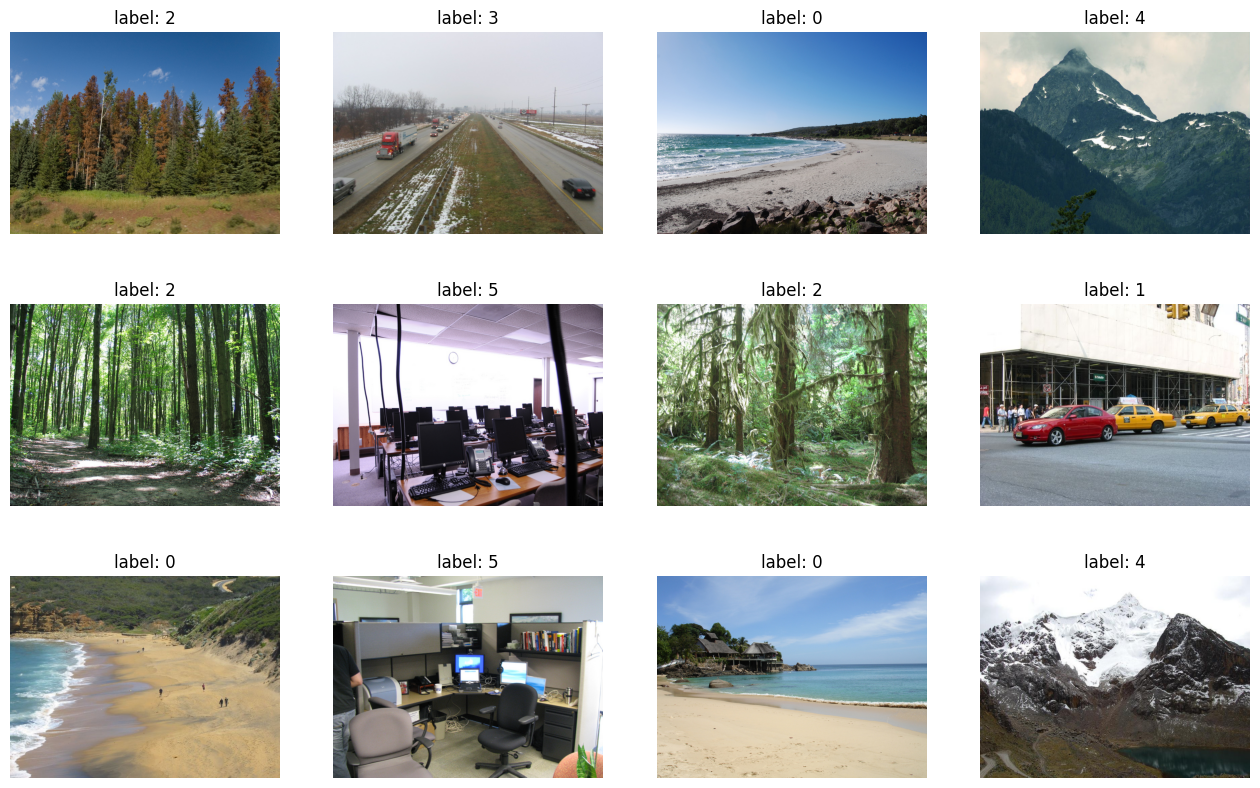

In [3]:
rst = np.random.RandomState(43)
f, axes = plt.subplots(3, 4, figsize=(16, 10))

for ax in axes.flatten():
    image, label = validation_dataset[rst.randint(len(validation_dataset))]
    ax.imshow(image.numpy().transpose(1, 2, 0))
    ax.set_title(f"label: {label}")
    ax.set_axis_off()

## Linear Classification

First, we want to try to classify the images with a simple linear classifier, which we implement in pytorch and train using crossentropy.

In [4]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    
)

val_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

In [5]:
class LinearClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # we first downsample by a factor of 10 to make things a bit simpler
        self.pool1 = torch.nn.AvgPool2d((10, 10))
        self.linear1 = torch.nn.Linear(60 * 80 * 3, 6)
    
    def forward(self, x):
        x = self.pool1(x)
        x = x.view(-1, 60 * 80 * 3)
        x = self.linear1(x)
        return x
    
model = LinearClassifier()

We train the classifier for crossentropy. We additionally employ a learning rate decay schedule: After certain numbers of epochs, the learning rate will be decayed by a factor of 10. You have to decide about optimizer, initial learning rate and decay schedule

In [6]:
# specify loss function
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.04, momentum=0.9, weight_decay=5e-4, nesterov=True) 
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20])  # choose two decay milestones

In [7]:
# number of epochs to train the model
n_epochs = 25 

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        #print(data.shape)
        #print(target.shape)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*data.size(0)
    lr_scheduler.step()
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 112.456992
Epoch: 2 	Training Loss: 77.831738
Epoch: 3 	Training Loss: 56.759677
Epoch: 4 	Training Loss: 64.444098
Epoch: 5 	Training Loss: 45.986560
Epoch: 6 	Training Loss: 41.624754
Epoch: 7 	Training Loss: 52.165638
Epoch: 8 	Training Loss: 49.233345
Epoch: 9 	Training Loss: 32.288157
Epoch: 10 	Training Loss: 23.583534
Epoch: 11 	Training Loss: 7.291181
Epoch: 12 	Training Loss: 4.739662
Epoch: 13 	Training Loss: 3.873042
Epoch: 14 	Training Loss: 3.324819
Epoch: 15 	Training Loss: 3.072670
Epoch: 16 	Training Loss: 2.413665
Epoch: 17 	Training Loss: 2.168824
Epoch: 18 	Training Loss: 2.084273
Epoch: 19 	Training Loss: 1.791407
Epoch: 20 	Training Loss: 1.800665
Epoch: 21 	Training Loss: 1.330187
Epoch: 22 	Training Loss: 1.248396
Epoch: 23 	Training Loss: 1.216682
Epoch: 24 	Training Loss: 1.196530
Epoch: 25 	Training Loss: 1.175357


In [8]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval() # prep model for *evaluation*

for data, target in val_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(val_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 41.076357

Test Accuracy of     0: 63% (12/19)
Test Accuracy of     1: 52% ( 9/17)
Test Accuracy of     2: 80% (12/15)
Test Accuracy of     3: 70% (12/17)
Test Accuracy of     4: 52% (10/19)
Test Accuracy of     5: 69% ( 9/13)

Test Accuracy (Overall): 64% (64/100)


#### Exercise 3.1

Try to find good choices for optimizer, initial learning rate and decay schedule. Does the linear classifier reach a good performance on the validation set? If not, what kind of reasons might be responsible for this?

##### RESULT #####

- First problem was that i didn't realize, that the unzipped data set was saved in an extra folder with the same name...
- All changes to the code have been reverted

- Optimizer:
---> Adam vs SGD?
---> I don't know enough to make a good decision here, but both seem to have benefits and drawbacks
---> As i don't use a GPU i will go for the SGD as that seems to require less computational effort and also runs more stable (according to Goolge)

- Learning rate:
---> step size towards optimal minimum
---> just try out?

- Momentum
---> helps to reduce fluctuations and accelerate convergence
---> 0.9 seems to be a balanced choice (fast learning/stability)

- Weight decay:
---> regulation that helps to avoid overfitting
---> typical values in the range of 1e-5 and 1e-2

- Nesterov:
---> More advanced than classical momentum
---> Tries to predict where the model is headed to correct early on

-Milestones:
---> The scheduler reduces the learning rate when certain milestones are reached
---> Why?
---> 
---> How to set the milestones correclty?
---> Analyse the loss history (but in general at 50% and 75% of epochs)
---> So for 25 epochs the milestones could be 10 and 20


---> Test run 1: lr=0.01,  momentum=0.9, weight decay=1e-4 ---> 64% accuracy
---> Test run 2: lr=0.01,  momentum=0.9, weight decay=1e-3 ---> 63% accuracy
---> Test run 3: lr=0.01,  momentum=0.7, weight decay=1e-3 ---> 60% accuracy
---> Test run 4: lr=0.001, momentum=0.7, weight decay=1e-2 ---> 61% accuracy
---> Test run 5: lr=0.001, momentum=0.9, weight decay=5e-4 ---> 60% accuracy
---> Test run 5: lr=0.02,  momentum=0.9, weight decay=1e-4 ---> 62% accuracy
---> Test run 6: lr=0.04,  momentum=0.9, weight decay=1e-4 ---> 62% accuracy
---> Test run 5: lr=0.04,  momentum=0.9, weight decay=5e-4 ---> 64% accuracy

---> Accuracy seems to be capped at 64% as neither a higher learning rate nor a change in weight decay does impact performance significantly

---> Linear classifier can't reach a good accuracy. 
---> Maybe because the pictures are too difficult to differentiate in regard to the relatively small number of pictures per class/folder?
---> While the "theme" of the picture sets might differ, they do have certain things in common. Most of the images do feature a sky. The color of the sky however does also change not only between the different sets but also between different pictures in a set. This and other similarities might be too difficult for the linear classifier.




### Linear Classifier on CLIP embedding

In this section, we'll employ transfer learning: Instead of learning a model from scratch, we'll put a linear readout on top of a pretrained CLIP vision encoder. We'll keep the CLIP model fixed and only train the linear readout.

In [10]:
# download and load the CLIP model. Depending on your internet connection, the download will take some time, but it need to be done only once.
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_model.eval()

# the tokenizer is a preprocessing for the text encoder that we'll need later.
tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [11]:
# for the CLIP model, we need a different preprocessing, which conveniently has been provided by `create_model_and_transforms`.
# This preprocessing transforms and crops the image to the required size for the model
# Because of this, we need to build dataset and data loaders again.

dataset = ImageFolder('image_dataset', transform=preprocess)
generator = torch.Generator().manual_seed(42)  # set seed to make split deterministic
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 100, 100], generator=generator)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    
)

val_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

In [12]:
class CLIPClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = clip_model
        # freeze the CLIP parameters
        for parameter in self.backbone.parameters():
            parameter.requires_grad = False
        self.readout = torch.nn.Linear(512, 6)
    
    def forward(self, x):
        # we don't want to train the CLIP model
        with torch.no_grad():
            embedding = self.backbone.encode_image(x)
        
        logits = self.readout(embedding)
        return logits
    
    def train(self, mode=True):
        super().train(mode=mode)
        # keep backbone in evalm mode
        self.backbone.eval()
    
model = CLIPClassifier()

In [13]:
# specify loss function
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6,9]) # adapt

In [14]:
# number of epochs to train the model
n_epochs = 10  # adapt

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        #print(data.shape)
        #print(target.shape)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        #print(data)
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*data.size(0)
    lr_scheduler.step()
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.680663
Epoch: 2 	Training Loss: 0.138147
Epoch: 3 	Training Loss: 0.072307
Epoch: 4 	Training Loss: 0.054457
Epoch: 5 	Training Loss: 0.052390
Epoch: 6 	Training Loss: 0.050293
Epoch: 7 	Training Loss: 0.048853
Epoch: 8 	Training Loss: 0.048635
Epoch: 9 	Training Loss: 0.048394
Epoch: 10 	Training Loss: 0.048228


In [15]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval() # prep model for *evaluation*

for data, target in val_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(val_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.054253

Test Accuracy of     0: 100% (19/19)
Test Accuracy of     1: 100% (17/17)
Test Accuracy of     2: 100% (15/15)
Test Accuracy of     3: 100% (17/17)
Test Accuracy of     4: 100% (19/19)
Test Accuracy of     5: 100% (13/13)

Test Accuracy (Overall): 100% (100/100)


#### Exercise 3.2

Select optimizer, initial learning rate and decay schedule to train the linear readout on top of the CLIP model. What kind of performance do you get? Is the result in some sense surprising? How is performance on validation and training set related to the results of the linear classifier trained in 3.1? How do you explain the differences? What kind of differences did you notice in the training dynamcis compared to the purely linear model above?

##### RESULT #####

---> Test run 1: lr=0.001, weight decay=1e-2 ---> 100% accuracy (25 epochs, milestones at 15,20,25)
---> Test run 2: lr=0.001, weight decay=1e-2 ---> 11%  accuracy (10 epochs, milestones at 3,6,9)                !? -> This is odd
---> Test run 3: lr=0.001, weight decay=1e-2 ---> 100% accuracy (15 epochs, milestones at 7,10,13)
---> Test run 4: lr=0.001, weight decay=1e-2 ---> 100% accuracy (10 epochs, milestones at 3,6,9)


---> The accuracy of 100% is impressive, however not comparable to the linear classifier as the CLIP model was trained on numerous data sets instead of just one.
---> Right from the start the training loss is very small compared to the linear classifier
---> There is almost no optimization needed to reach perfect accuracy (except for setting the milestones)
---> Somehow the second run with 10 epochs was exceptionally bad. After checking 15 epochs and reaching perfect accuracy i tried 10 epochs again and it worked just fine. 
---> Googled for possible reasons but couldn't find anything as the model isn't being trained here and the seed is data split into training and validation data is always the same


## CLIP with zero shot text based classification

One of the special properties of CLIP models is that they are not just image models, but a vision language model. This facilitates zero shot classification using text queries. This example demonstrates how you can compute scores (logits) for different text queries given an image

In [16]:
text = tokenizer(["a diagram", "a dog", "a cat"])
image = train_dataset[0][0].unsqueeze(0)

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = clip_model.encode_image(image)
    text_features = clip_model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_logits = (100.0 * image_features @ text_features.T)
    text_probabilities = text_logits.softmax(dim=-1)
    print(text_probabilities)

C:\Users\svens\AppData\Local\Temp\ipykernel_23840\315541603.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
c:\Users\svens\OneDrive\Desktop\Python\2_Computational_Physics\Machine_Learning\.venv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


tensor([[0.4938, 0.4909, 0.0153]])


Use this example to construct a text based classifier. The `text_logits` from the example are essentially what used to be the model output previously. Since we're now in a *zero-shot setting*, there is no training involved and we only need to the evaluation loop.

In [26]:
# these are the text queries that characterize the different classes in the dataset. You'll need to find good queries yourself.
queries = [
    'beach',
    'buildings, cars, traffic lights, public places',
    'forest',
    'highway',
    'mountains',
    'office',
]

text = tokenizer(queries)
text_features = clip_model.encode_text(text)
text_features /= text_features.norm(dim=-1, keepdim=True)

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval() # prep model for *evaluation*

for data, target in val_loader:
    # TODO: compute text_logits as in the example in the previous cell
    # note that the text features are already computed because they
    # don't change from image to image
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = clip_model.encode_image(data)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    text_logits = (100.0 * image_features @ text_features.T)
    
    # calculate the loss
    loss = criterion(text_logits, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(text_logits, 1) # text_logits statt "output"
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(val_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
        

C:\Users\svens\AppData\Local\Temp\ipykernel_23840\2207223321.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Test Loss: 0.017113

Test Accuracy of     0: 100% (19/19)
Test Accuracy of     1: 100% (17/17)
Test Accuracy of     2: 100% (15/15)
Test Accuracy of     3: 100% (17/17)
Test Accuracy of     4: 100% (19/19)
Test Accuracy of     5: 100% (13/13)

Test Accuracy (Overall): 100% (100/100)


#### Exercise 3.3

Complete the above snippet for the text-based classifier and make it work. Try to find good text queries for the six different classes. What kind of performance do you get? How did you find the queries? What are advantages and disadvantages compared to the linear classifier?

##### RESULTS #####

---> Initial thoughts:
---> Try to find short and precice queries, only go into more detail for the two relatively similar picture sets (city/highway)
---> Only provide more detail where it is necessary to avoid misinterpretation of ambigous queries

---> Test run 1: beach, city with large buildings, forest, highway, mountains, office ---> 94% accuracy (100% on all sets except the second where the accuracy is 64%)
---> Just out of curiosity i wanted to try if singular/plural does have an impact on accuracy.
---> It didn't. At least not for the set for whicht the corresponding query has been modified.
---> Test run 2: beach, city with large buildings, forest, highway, mountain, office ---> 92% accuracy (accuracy for second set decreased to 52%)
---> Test run 3: beach, city with large buildings and cars and traffic lights, forest, highway, mountains, office ---> 97% accuracy (accuracy of 88% on second set)
---> Try without "city" as that might already be difficult to classify as it in itself has multiple conditions and requirements
---> Test run 4: beach, large buildings and cars and traffic lights, forest, highway, mountains, office ---> 98% accuracy (accuracy of 94% on second set)
---> Try without "large" as that is very subjective
---> Test run 5: beach, buildings and cars and traffic lights, forest, highway, mountains, office ---> 98% accuracy (accuracy of 94% on second set, no change)
---> Try with "," instead of "and" as not all pictures exhibit all of the features
---> Test run 5: beach, (buildings, cars, traffic lights), forest, highway, mountains, office ---> 99% accuracy (accuracy of 94% on second set, no change)
---> Add "public places" to query as there are some pictures that might benfit from this 
---> Test run 6: beach, (buildings, cars, traffic lights, public places), forest, highway, mountains, office ---> 100% accuracy 

---> 90%(+) from the beginning and perfect score after only 6 runs, even though the second shouldn't really count as that was out of curiosity and not necessarily related to the task.

### ADVANTAGES AND DISADVANTAGES OF CLIP ###

## + ##
---> Zero shot ability, does not need to be trained for a new/specific data set
---> a bit more "wysiwyg", text queries are more intuitive and the result of specific queries can be matched easily.
---> Forces attention to detail without being to complicated to follow

## - ##
---> Does need very specific queries and doesn't have "commom sense"
---> Probably less efficient than a linear classifier


### Text based Image Retrieval

Image retrieval is the task of finding the best matching image given a certain query that here will be formulated as text. Because no training is needed anymore, we'll now use the full dataset

In [27]:
raw_dataset = ImageFolder('image_dataset')  # we'll need this later to display the original images
dataset = ImageFolder('image_dataset', transform=preprocess)

To do so, we first need to build a database of CLIP embeddings for all candidate images.

In [28]:
# We compute normalized images features for each image in the training dataset
# and concatenate them into a (N_images, N_features) dimensional torch tensor that then can be used for fast image querying.
embeddings = []
labels = []

for image, label in tqdm(dataset):
    image_tensor = image.unsqueeze(0)
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = clip_model.encode_image(image_tensor)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    # save image features
    embeddings.append(image_features)
    labels.append(label)

# build "embedding database"
embeddings = torch.concat(embeddings)

  0%|          | 0/475 [00:00<?, ?it/s]C:\Users\svens\AppData\Local\Temp\ipykernel_23840\3417357384.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
100%|██████████| 475/475 [00:43<00:00, 10.91it/s]


This is the image that we want to find in the dataset:

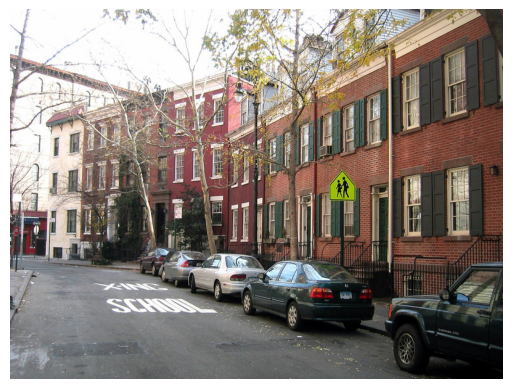

In [29]:
plt.imshow(raw_dataset[100][0])
plt.axis('off');

To find images matching a text query, instead of matching one image against multiple texts, we'll now match many images against one text. By sorting the images according to the returned CLIP scores, we can display the most promising matches.

C:\Users\svens\AppData\Local\Temp\ipykernel_23840\186997173.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


100
87
118
96
83


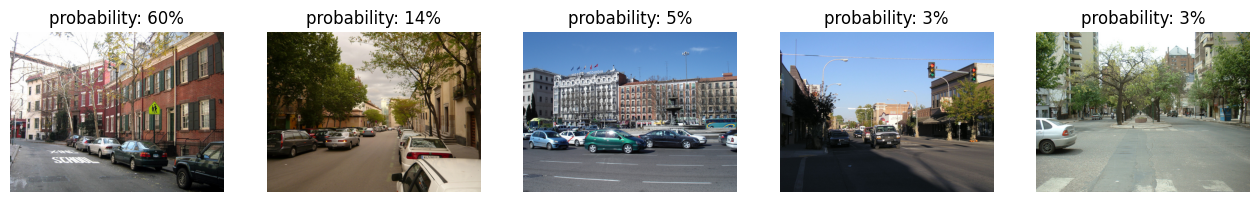

In [ ]:
query = '"school" writing on road, five cars (green and white), fall, tree, apartment building, yellow pedestrian sign'  # fill in

text = tokenizer(query)

# compute probabilities for each image given the text query
# this is very similar to the snippets above, but be
# careful: now we're not interested in probabilites for each text query
# but in probabilities for each image. Hence there will be subtle changes
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    image_logits = (100.0 * text_features @ embeddings.T)
    image_probabilities = image_logits.softmax(dim=-1).squeeze()
    
sorted_indices = np.argsort(image_probabilities.numpy())
sorted_indices = sorted_indices[::-1]
    
f, axes = plt.subplots(1, 5, figsize=(16, 4))
for index, ax in zip(sorted_indices, axes):
    print(index)
    image = raw_dataset[index][0]
    ax.imshow(image)
    ax.set_axis_off()
    ax.set_title(f"probability: {image_probabilities[index].numpy():.0%}")


#### Excercise 3.4

Complete the code above and find a text query that returns the target image as best matching candidate. How well can you separate it from other images? With other words, how high can you drive the assigned probability for the correct image? Descrie how you found the query that you used in the end.

##### RESULTS #####

---> Test run 1: road, five cars to the right, bright yellow pedestrian sign, apartment buildings on the right side of the road ---> 42, 11 (TARGET), 9, 4, 4 % accuracy
---> Try to foucs on differences 
---> Test run 2: road, cars facing away, bright yellow pedestrian sign, buildings only to the right ---> 42, 11 (TARGET), 9, 4, 4 % accuracy
---> Query to difficult? There is NO change at all...
---> Use more but shorter queries
---> Test run 3: road, writing on road, five cars, fall, red apartment building, yellow pedestrian sign ---> 56 (TARGET), 27, 4, 4, 4 % accuracy
---> Reduce duplicates and 
---> Test run 4: writing on road, five cars, fall, apartment building, yellow pedestrian sign ---> 68 (TARGET), 13, 9, 1, 1 % accuracy
---> Add tree query to differentiate from second and third picture
---> Test run 5: writing on road, five cars, fall, tree, apartment building, yellow pedestrian sign ---> 81 (TARGET), 9, 3, 1, 1 % accuracy
---> Try to focus on the word "school" written on the road. Unsure if this is possible...
---> Test run 6: "school" writing on road, five cars, fall, apartment building, yellow pedestrian sign ---> 84 (TARGET), 5, 4, 2, 1 % accuracy
---> If this works, then maybe i can also specify the car colour?
---> Test run 7: writing on road, five cars (green and white), fall, apartment building, yellow pedestrian sign ---> 85 (TARGET), 4, 3, 2, 1 % accuracy
---> Specifying ALL car colours doesn't work -> accuracy decreases to (+/-) 70%
---> Specifying the apartment building colour doesn't work, same goes for the colour fo the shutters
---> "white sky" or "overexposed sky" also decrease the accuracy

---> 85% seems to be the best result i can achieve
